# Лабораторная работа 4: Кластеризация

**Выполнил:** [Ваше ФИО]

**Группа:** [Номер группы]

**Вариант:** 2 (employee_attrition.csv)

## Часть 1: Работа с синтетическими данными

В первой части лабораторной работы мы будем работать с синтетическими данными, созданными специальной функцией.

### 1.1. Импорт необходимых библиотек

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics.cluster import fowlkes_mallows_score, homogeneity_score
from sklearn.metrics.cluster import completeness_score, v_measure_score
from scipy.cluster.hierarchy import dendrogram, linkage
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

### 1.2. Создание функции для генерации данных

In [4]:
def make_data(n, seed):
    np.random.seed(seed)

    shift_matrix = np.array([[3, 3],
                             [6, 9],
                             [9, 3]])

    data = np.random.randn(3, 2, n) + shift_matrix.reshape((3, 2, 1))
    data = np.swapaxes(data, 1, 2)
    data = data.reshape((-1, 2))
    data *= np.array([[20, 0.5]])

    df = pd.DataFrame({'x': data[:, 0], 'y': data[:, 1]},
                     columns=['x', 'y'])
    df = df.sample(frac=1.0)
    return df

### 1.3. Генерация набора данных



Создаем набор данных с параметрами:
- n = 50 (по 50 объектов в каждой из 3 групп, итого 150 объектов)
- seed = 42 (для воспроизводимости результатов)

In [6]:
df = make_data(n=50, seed=42)

print(df.head())
print(f"Размерность данных: {df.shape}")
print(df.describe())

             x         y
33   38.845781  1.240865
23   31.505036  2.282322
50   91.692585  4.625246
63  169.264842  4.089659
88  136.270344  4.076603
Размерность данных: (150, 2)
                x           y
count  150.000000  150.000000
mean   119.241386    2.513417
std     55.999458    1.515214
min     20.806598   -0.120634
25%     67.032764    1.346669
50%    120.337163    1.859191
75%    166.959349    4.115373
max    257.054630    5.860085


Получился датасет из 150 объектов с двумя признаками x и y. Признаки имеют разные масштабы, что требует стандартизации перед применением алгоритмов кластеризации.

### 1.4. Визуализация исходных данных

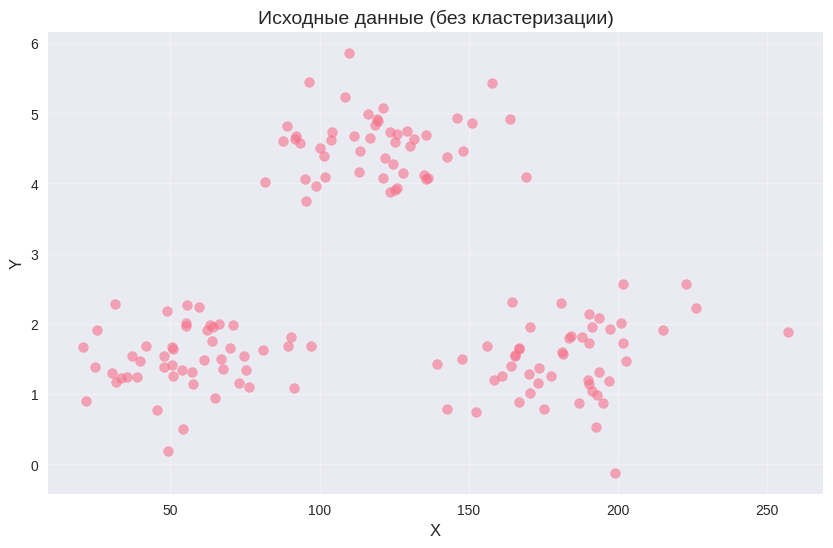

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(df['x'], df['y'], alpha=0.6, s=50)
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title('Исходные данные (без кластеризации)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

На графике визуально можно выделить несколько групп объектов. Для формальной кластеризации применим алгоритм K-means.

### 1.5. Стандартизация данных

Алгоритмы кластеризации чувствительны к масштабу признаков, поэтому необходимо провести стандартизацию.

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

print("Стандартизированные данные (первые 5 строк):")
print(X_scaled[:5])
print(f"Среднее по признакам: {X_scaled.mean(axis=0)}")
print(f"Стандартное отклонение по признакам: {X_scaled.std(axis=0)}")

Стандартизированные данные (первые 5 строк):
[[-1.44045926 -0.84266293]
 [-1.57198442 -0.15302729]
 [-0.4935957   1.39841883]
 [ 0.89627725  1.04376155]
 [ 0.30511023  1.03511628]]
Среднее по признакам: [ 2.94579176e-16 -4.32246831e-16]
Стандартное отклонение по признакам: [1. 1.]


После стандартизации все признаки имеют среднее близкое к 0 и стандартное отклонение равное 1, что обеспечивает равный вклад всех признаков в результат кластеризации.

### 1.6. K-means с 3 кластерами

In [16]:
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_3 = kmeans_3.fit_predict(X_scaled)

centers_3 = kmeans_3.cluster_centers_

silhouette_3 = silhouette_score(X_scaled, clusters_3)

print(f"Метки кластеров (первые 10): {clusters_3[:10]}")
print(f"Коэффициент силуэта для 3 кластеров: {silhouette_3:.4f}")

Метки кластеров (первые 10): [2 2 0 0 0 0 0 2 0 2]
Коэффициент силуэта для 3 кластеров: 0.7242


Модель K-means успешно разделила данные на 3 кластера. Коэффициент силуэта показывает качество кластеризации (значения близкие к 1 указывают на хорошее разделение).

### 1.7. Визуализация результатов для 3 кластеров

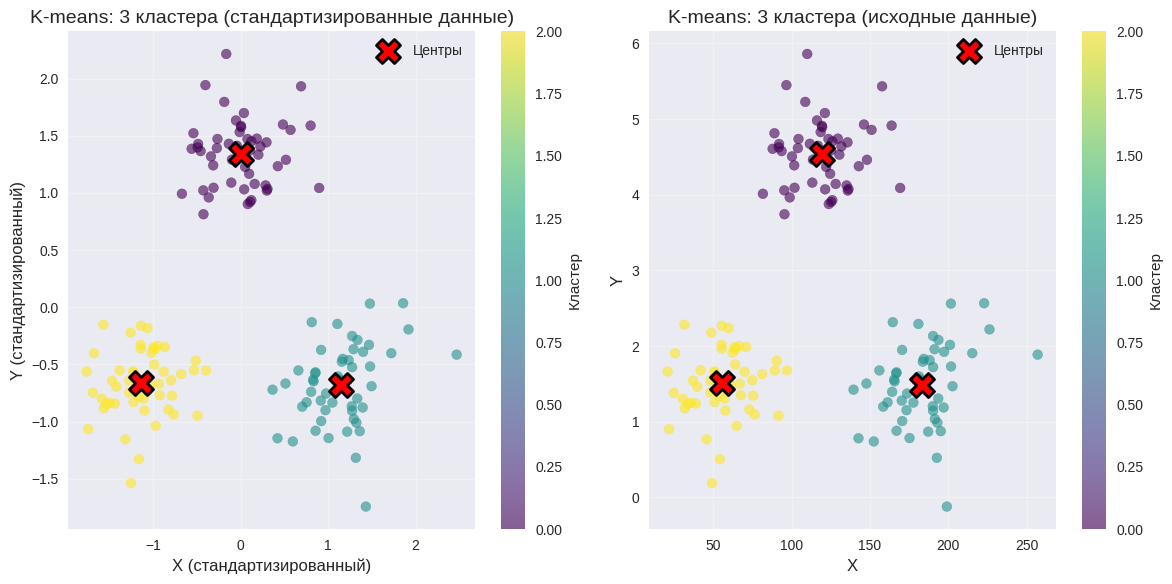

In [17]:
# Преобразование центров обратно в исходный масштаб для визуализации
centers_3_original = scaler.inverse_transform(centers_3)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters_3,
                     cmap='viridis', alpha=0.6, s=50)
plt.scatter(centers_3[:, 0], centers_3[:, 1], c='red', marker='X',
           s=300, edgecolors='black', linewidths=2, label='Центры')
plt.xlabel('X (стандартизированный)', fontsize=12)
plt.ylabel('Y (стандартизированный)', fontsize=12)
plt.title('K-means: 3 кластера (стандартизированные данные)', fontsize=14)
plt.colorbar(scatter, label='Кластер')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
scatter = plt.scatter(df['x'], df['y'], c=clusters_3,
                     cmap='viridis', alpha=0.6, s=50)
plt.scatter(centers_3_original[:, 0], centers_3_original[:, 1],
           c='red', marker='X', s=300, edgecolors='black',
           linewidths=2, label='Центры')
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title('K-means: 3 кластера (исходные данные)', fontsize=14)
plt.colorbar(scatter, label='Кластер')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Алгоритм K-means успешно выделил 3 визуально различимые группы. Центры кластеров (красные крестики) находятся в центре плотности каждой группы объектов.

### 1.8. K-means с 2 кластерами

In [18]:
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters_2 = kmeans_2.fit_predict(X_scaled)

centers_2 = kmeans_2.cluster_centers_
centers_2_original = scaler.inverse_transform(centers_2)

silhouette_2 = silhouette_score(X_scaled, clusters_2)

print(f"Коэффициент силуэта для 2 кластеров: {silhouette_2:.4f}")

Коэффициент силуэта для 2 кластеров: 0.4989


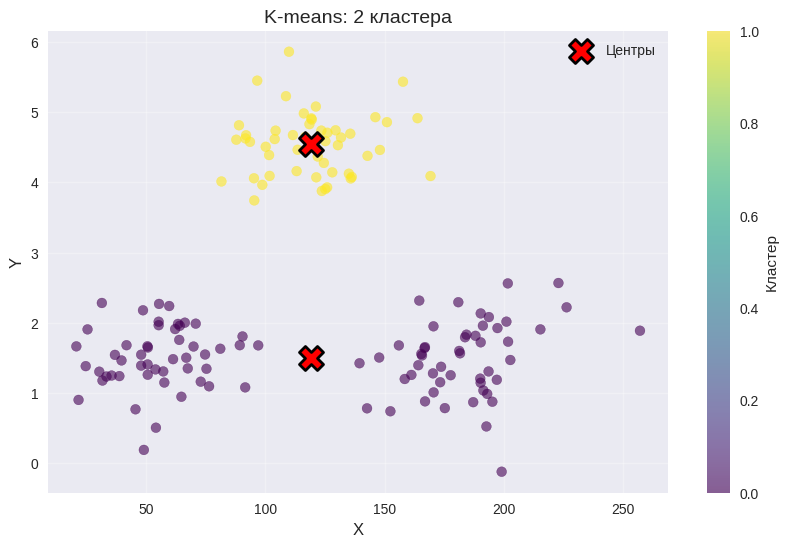

In [19]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['x'], df['y'], c=clusters_2,
                     cmap='viridis', alpha=0.6, s=50)
plt.scatter(centers_2_original[:, 0], centers_2_original[:, 1],
           c='red', marker='X', s=300, edgecolors='black',
           linewidths=2, label='Центры')
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title('K-means: 2 кластера', fontsize=14)
plt.colorbar(scatter, label='Кластер')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

При разделении на 2 кластера алгоритм объединяет некоторые визуально различимые группы, что не вполне соответствует истинной структуре данных.

### 1.9. K-means с 4 кластерами

In [20]:
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters_4 = kmeans_4.fit_predict(X_scaled)

centers_4 = kmeans_4.cluster_centers_
centers_4_original = scaler.inverse_transform(centers_4)

silhouette_4 = silhouette_score(X_scaled, clusters_4)

print(f"Коэффициент силуэта для 4 кластеров: {silhouette_4:.4f}")

Коэффициент силуэта для 4 кластеров: 0.6105


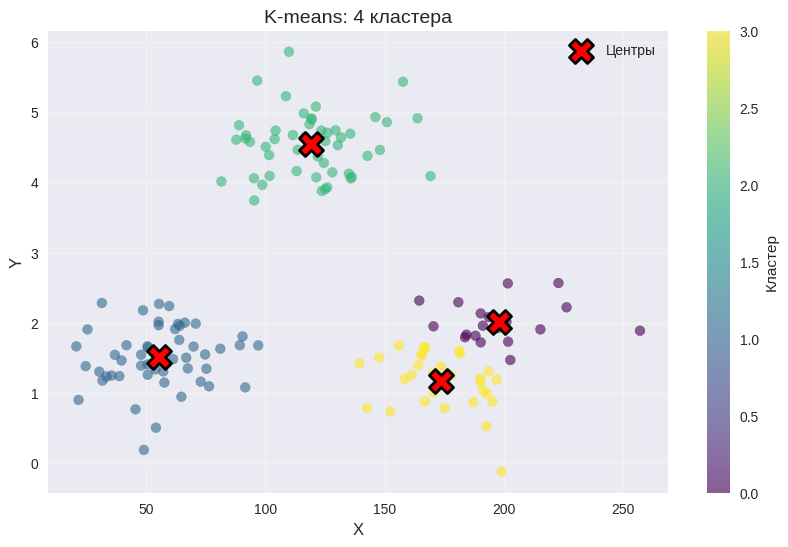

In [21]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['x'], df['y'], c=clusters_4,
                     cmap='viridis', alpha=0.6, s=50)
plt.scatter(centers_4_original[:, 0], centers_4_original[:, 1],
           c='red', marker='X', s=300, edgecolors='black',
           linewidths=2, label='Центры')
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title('K-means: 4 кластера', fontsize=14)
plt.colorbar(scatter, label='Кластер')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

При разделении на 4 кластера происходит избыточная фрагментация данных - один из истинных кластеров разделяется на части.

### 1.10. Сравнение результатов для разного количества кластеров

Сравнение результатов кластеризации:
 Количество кластеров  Коэффициент силуэта    Inertia
                    2             0.498910 164.673879
                    3             0.724205  34.144525
                    4             0.610480  28.275933


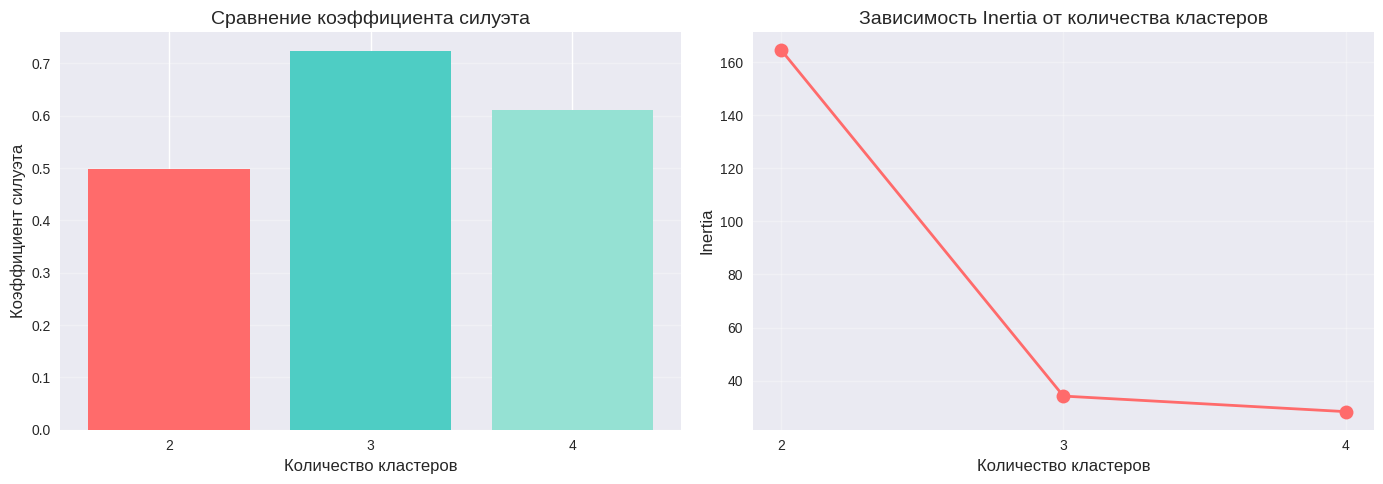

In [22]:
# Создание таблицы сравнения
comparison_df = pd.DataFrame({
    'Количество кластеров': [2, 3, 4],
    'Коэффициент силуэта': [silhouette_2, silhouette_3, silhouette_4],
    'Inertia': [kmeans_2.inertia_, kmeans_3.inertia_, kmeans_4.inertia_]
})

print("Сравнение результатов кластеризации:")
print(comparison_df.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График коэффициента силуэта
axes[0].bar([2, 3, 4], [silhouette_2, silhouette_3, silhouette_4],
           color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
axes[0].set_xlabel('Количество кластеров', fontsize=12)
axes[0].set_ylabel('Коэффициент силуэта', fontsize=12)
axes[0].set_title('Сравнение коэффициента силуэта', fontsize=14)
axes[0].set_xticks([2, 3, 4])
axes[0].grid(True, alpha=0.3, axis='y')

# График Inertia
axes[1].plot([2, 3, 4], [kmeans_2.inertia_, kmeans_3.inertia_, kmeans_4.inertia_],
            marker='o', linewidth=2, markersize=10, color='#FF6B6B')
axes[1].set_xlabel('Количество кластеров', fontsize=12)
axes[1].set_ylabel('Inertia', fontsize=12)
axes[1].set_title('Зависимость Inertia от количества кластеров', fontsize=14)
axes[1].set_xticks([2, 3, 4])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Вывод:**
- Наибольший коэффициент силуэта наблюдается для k=3, что указывает на лучшее качество кластеризации, что было изначально наглядно видно на визулизации данных
- Значение Inertia монотонно убывает с увеличением k
- Оптимальное количество кластеров: **3**

### 1.11. Метод локтя (Elbow Method)




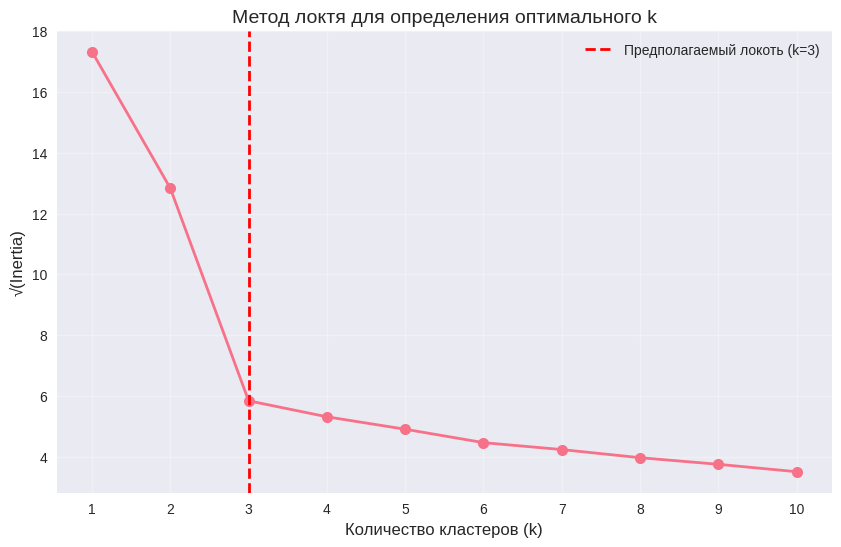

In [23]:
inertia_values = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia_values.append(np.sqrt(kmeans.inertia_))

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia_values, marker='o', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров (k)', fontsize=12)
plt.ylabel('√(Inertia)', fontsize=12)
plt.title('Метод локтя для определения оптимального k', fontsize=14)
plt.xticks(K_range)
plt.grid(True, alpha=0.3)

plt.axvline(x=3, color='red', linestyle='--', linewidth=2, label='Предполагаемый локоть (k=3)')
plt.legend()
plt.show()

На графике метода локтя наблюдается заметный изгиб ("локоть") в точке k=3, после которой снижение inertia становится более плавным. Это подтверждает, что оптимальное количество кластеров равно 3.

### 1.12. Использование KElbowVisualizer из yellowbrick

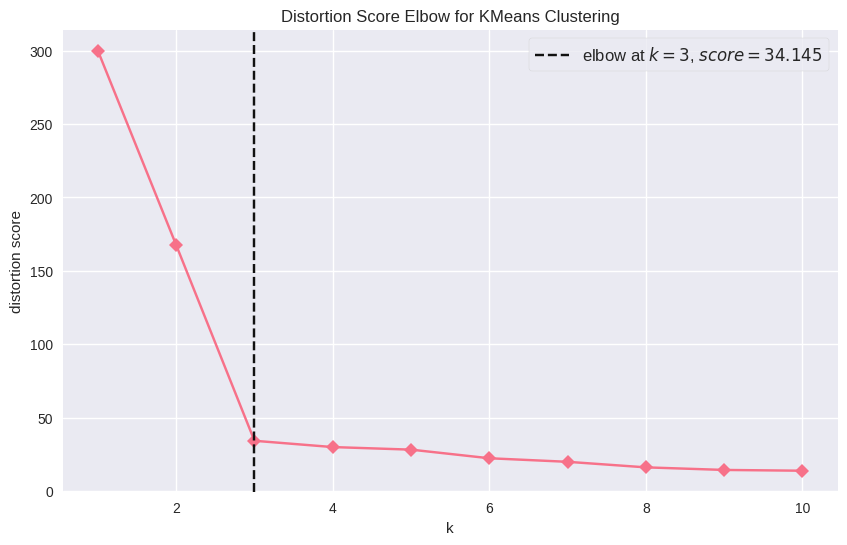

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
plt.figure(figsize=(10, 6))
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(1, 11), timings=False)
visualizer.fit(X_scaled)
visualizer.show()

Визуализатор KElbowVisualizer автоматически определил оптимальное количество кластеров, что согласуется с нашими предыдущими выводами.

---
## Часть 2: Кластеризация реальных данных (Вариант 2)

### Датасет: employee_attrition.csv
Анализ увольнений сотрудников компании

### 2.1. Загрузка и первичный анализ данных

In [26]:
df_emp = pd.read_csv('employee_attrition.csv')

print("Первые 10 строк данных:")
print(df_emp.head(10))

print("Информация о датасете:")
print(df_emp.info())

print("Размерность данных:")
print(df_emp.shape)

print("Описательная статистика:")
print(df_emp.describe())

Первые 10 строк данных:
   age gender   department  job_level marital_status  monthly_income  \
0   31      F  Engineering          1         Single          5163.0   
1   29      M        Sales          2       Divorced         13878.0   
2   26      F      Support          1        Married          4712.0   
3   61      F  Engineering          2         Single         12196.0   
4   59      F        Sales          5         Single         15823.0   
5   57      F      Finance          1       Divorced          4933.0   
6   23      M  Engineering          1        Married          4612.0   
7   41      F      Finance          3         Single          5881.0   
8   55      F           HR          1        Married          4688.0   
9   24      F      Finance          3         Single          1985.0   

   years_at_company overtime  performance_rating  distance_from_home_km  \
0                14       No                   3                   24.1   
1                 1       No     

Датасет содержит информацию о сотрудниках компании, включая как числовые, так и категориальные признаки.

### 2.2. Проверка пропущенных значений

In [30]:
missing_values = df_emp.isnull().sum()
print(missing_values)
print("Пропущенных значений не обнаружено")

age                         0
gender                      0
department                  0
job_level                   0
marital_status              0
monthly_income              0
years_at_company            0
overtime                    0
performance_rating          0
distance_from_home_km       0
training_hours_last_year    0
Attrition                   0
dtype: int64
Пропущенных значений не обнаружено


### 2.3. Анализ целевой переменной (Attrition)

Распределение целевой переменной (Attrition):
Не уволились (0): 2770 (90.88%)
Уволились (1): 278 (9.12%)


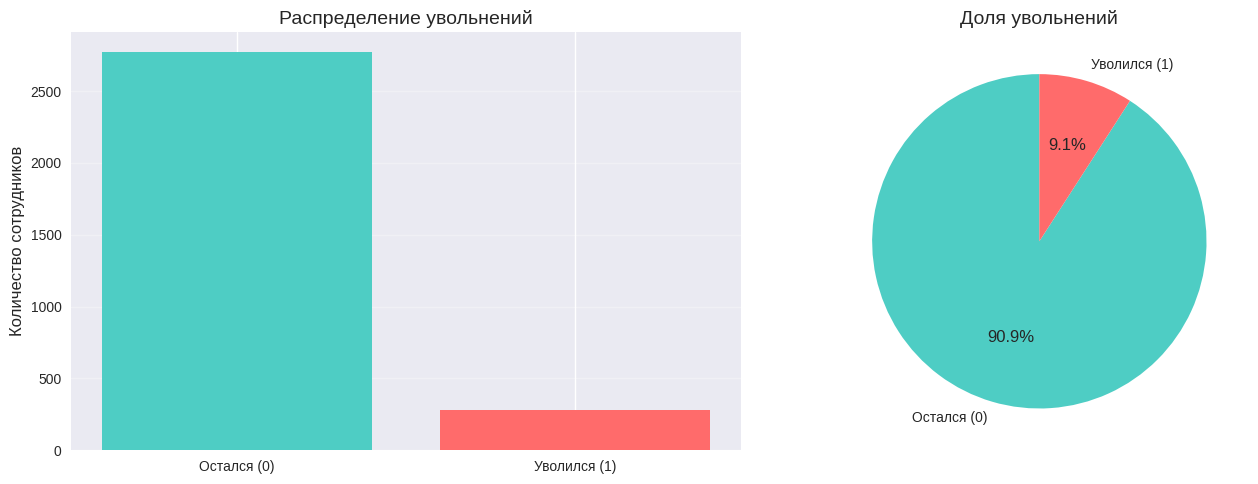

In [31]:
attrition_counts = df_emp['Attrition'].value_counts()
attrition_percent = df_emp['Attrition'].value_counts(normalize=True) * 100

print("Распределение целевой переменной (Attrition):")
print(f"Не уволились (0): {attrition_counts[0]} ({attrition_percent[0]:.2f}%)")
print(f"Уволились (1): {attrition_counts[1]} ({attrition_percent[1]:.2f}%)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(['Остался (0)', 'Уволился (1)'], attrition_counts.values,
           color=['#4ECDC4', '#FF6B6B'])
axes[0].set_ylabel('Количество сотрудников', fontsize=12)
axes[0].set_title('Распределение увольнений', fontsize=14)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].pie(attrition_counts.values, labels=['Остался (0)', 'Уволился (1)'],
           autopct='%1.1f%%', colors=['#4ECDC4', '#FF6B6B'], startangle=90)
axes[1].set_title('Доля увольнений', fontsize=14)

plt.tight_layout()
plt.show()

### 2.4. Анализ категориальных признаков

In [33]:
categorical_features = df_emp.select_dtypes(include=['object']).columns.tolist()
if 'Attrition' in categorical_features:
    categorical_features.remove('Attrition')

print(f"Категориальные признаки: {categorical_features}")

for feature in categorical_features:
    print(f"\n{feature}:")
    print(df_emp[feature].value_counts())

Категориальные признаки: ['gender', 'department', 'marital_status', 'overtime']

gender:
gender
M    1539
F    1509
Name: count, dtype: int64

department:
department
Engineering    1051
Sales           788
Support         526
Finance         443
HR              240
Name: count, dtype: int64

marital_status:
marital_status
Married     1470
Single      1220
Divorced     358
Name: count, dtype: int64

overtime:
overtime
No     2201
Yes     847
Name: count, dtype: int64


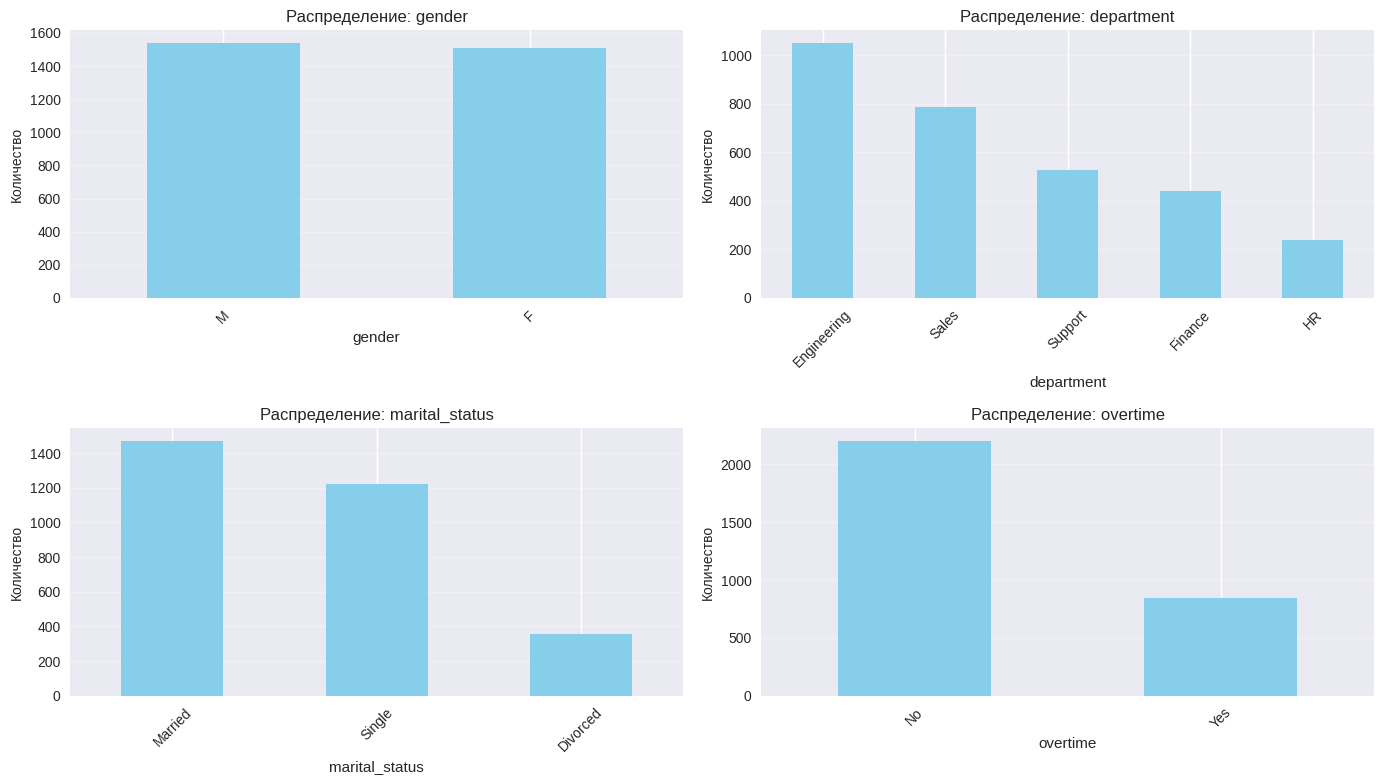

In [34]:
n_cat = len(categorical_features)
fig, axes = plt.subplots((n_cat + 1) // 2, 2, figsize=(14, 4 * ((n_cat + 1) // 2)))
axes = axes.flatten() if n_cat > 1 else [axes]

for idx, feature in enumerate(categorical_features):
    df_emp[feature].value_counts().plot(kind='bar', ax=axes[idx], color='skyblue')
    axes[idx].set_title(f'Распределение: {feature}', fontsize=12)
    axes[idx].set_ylabel('Количество', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3, axis='y')

for idx in range(n_cat, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

Проанализировали распределение категориальных признаков. Все признаки требуют кодирования перед применением алгоритмов кластеризации.

### 2.5. Анализ числовых признаков

In [36]:
numerical_features = df_emp.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Attrition' in numerical_features:
    numerical_features.remove('Attrition')

print(f"Числовые признаки: {numerical_features}")
print(df_emp[numerical_features].describe())

Числовые признаки: ['age', 'job_level', 'monthly_income', 'years_at_company', 'performance_rating', 'distance_from_home_km', 'training_hours_last_year']
               age    job_level  monthly_income  years_at_company  \
count  3048.000000  3048.000000     3048.000000       3048.000000   
mean     41.308071     2.188976     7727.857283         20.102362   
std      13.431709     1.165800     4058.833918         11.826501   
min      18.000000     1.000000     1488.000000          0.000000   
25%      30.000000     1.000000     4901.750000         10.000000   
50%      42.000000     2.000000     6733.000000         20.000000   
75%      53.000000     3.000000     9529.500000         30.000000   
max      64.000000     5.000000    35395.000000         40.000000   

       performance_rating  distance_from_home_km  training_hours_last_year  
count         3048.000000            3048.000000               3048.000000  
mean             2.838583              10.236490                104.930

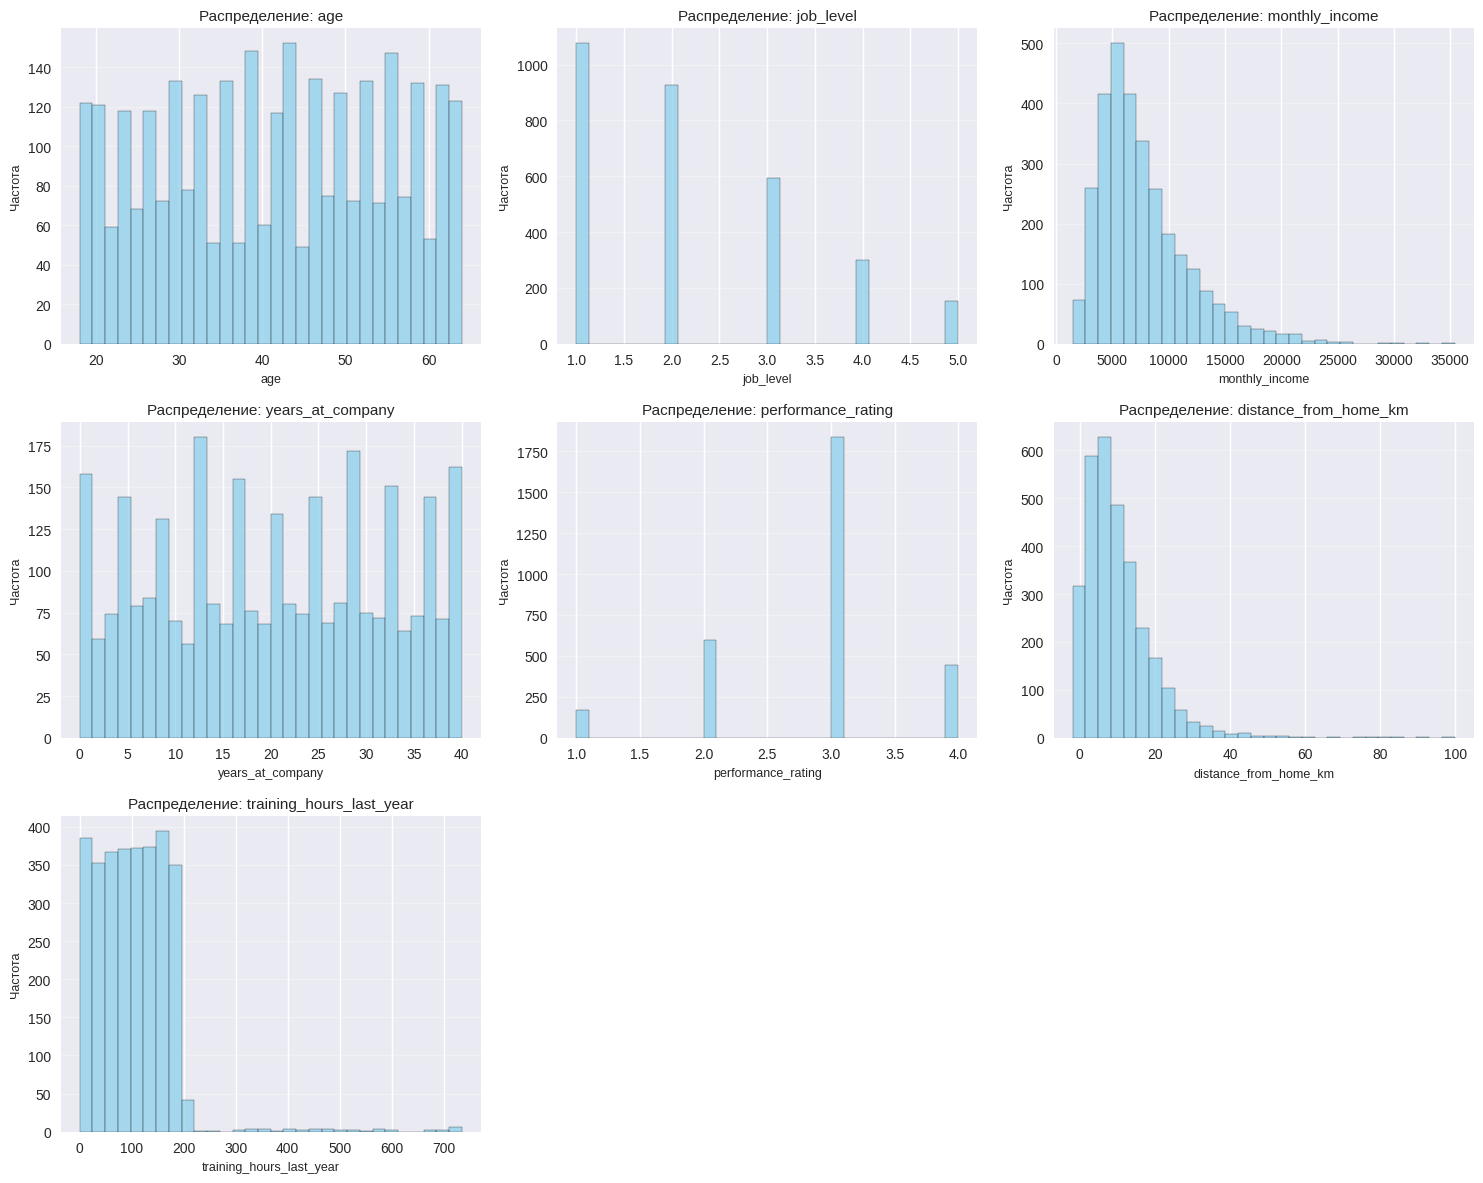

In [37]:
n_num = len(numerical_features)
fig, axes = plt.subplots((n_num + 2) // 3, 3, figsize=(15, 4 * ((n_num + 2) // 3)))
axes = axes.flatten() if n_num > 1 else [axes]

for idx, feature in enumerate(numerical_features):
    axes[idx].hist(df_emp[feature], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Распределение: {feature}', fontsize=11)
    axes[idx].set_xlabel(feature, fontsize=9)
    axes[idx].set_ylabel('Частота', fontsize=9)
    axes[idx].grid(True, alpha=0.3, axis='y')

for idx in range(n_num, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

Проанализировали распределение числовых признаков. Некоторые признаки имеют сильно различающиеся масштабы, что подчеркивает необходимость стандартизации.

### 2.6. Корреляционная матрица

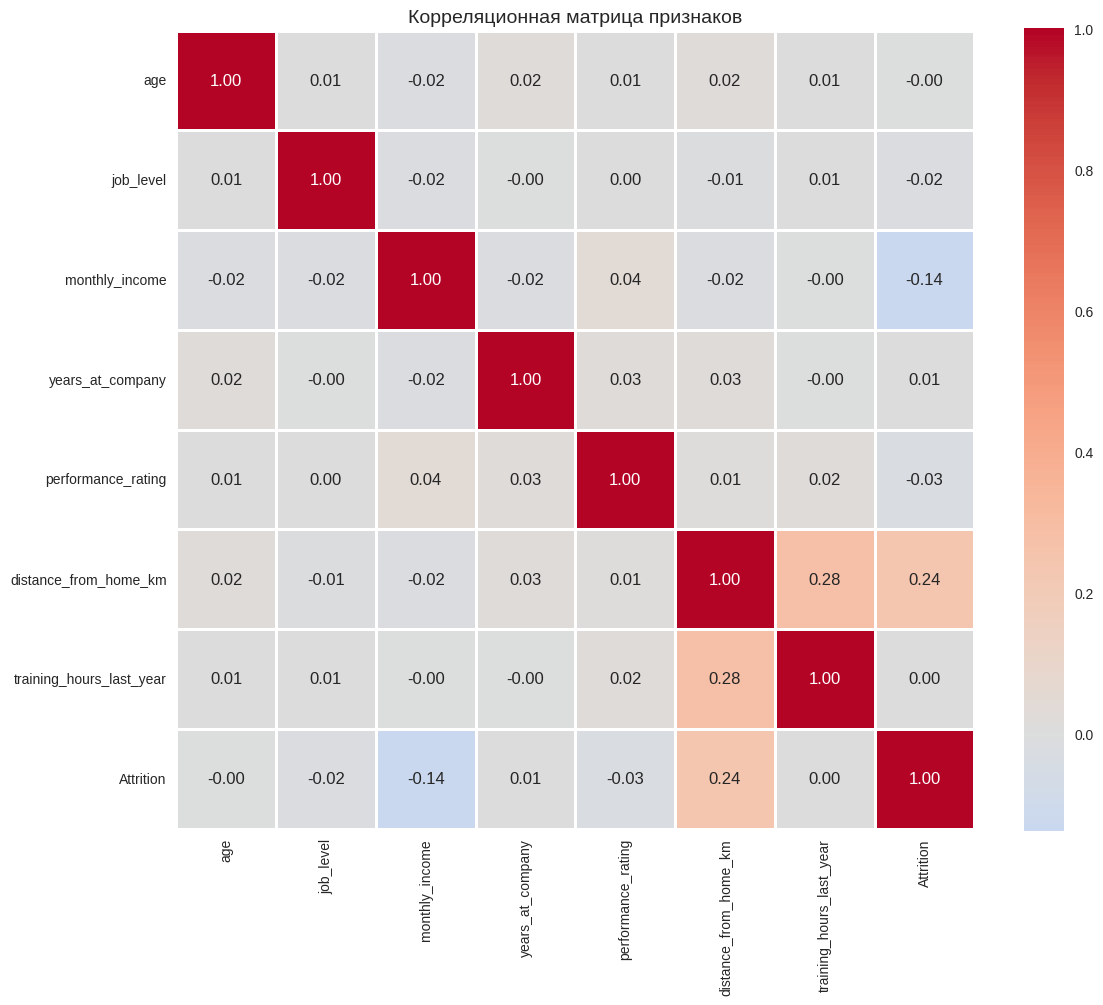

Корреляция признаков с Attrition (топ-5 по абсолютному значению):
distance_from_home_km    0.244010
monthly_income           0.138068
performance_rating       0.025048
job_level                0.021054
years_at_company         0.006895
Name: Attrition, dtype: float64


In [38]:
plt.figure(figsize=(12, 10))
correlation_matrix = df_emp[numerical_features + ['Attrition']].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
           center=0, square=True, linewidths=1)
plt.title('Корреляционная матрица признаков', fontsize=14)
plt.tight_layout()
plt.show()

print("Корреляция признаков с Attrition (топ-5 по абсолютному значению):")
attrition_corr = correlation_matrix['Attrition'].drop('Attrition').abs().sort_values(ascending=False)
print(attrition_corr.head())

Корреляционная матрица показывает взаимосвязи между признаками. Это поможет понять, какие признаки наиболее важны для предсказания увольнений.

### 2.7. Подготовка данных для кластеризации

In [39]:
df_clustering = df_emp.copy()

y = df_clustering['Attrition']
X = df_clustering.drop('Attrition', axis=1)

print(f"Размерность X: {X.shape}")
print(f"Размерность y: {y.shape}")

Размерность X: (3048, 11)
Размерность y: (3048,)


### 2.8. Кодирование категориальных признаков

In [41]:
label_encoders = {}

for column in categorical_features:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le
    print(f"Закодирован признак '{column}': {dict(zip(le.classes_, le.transform(le.classes_)))}")

print("Первые 5 строк после кодирования:")
print(X.head())

Закодирован признак 'gender': {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
Закодирован признак 'department': {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4)}
Закодирован признак 'marital_status': {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2)}
Закодирован признак 'overtime': {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
Первые 5 строк после кодирования:
   age  gender  department  job_level  marital_status  monthly_income  \
0   31       0           0          1               2          5163.0   
1   29       1           3          2               0         13878.0   
2   26       0           4          1               1          4712.0   
3   61       0           0          2               2         12196.0   
4   59       0           3          5               2         15823.0   

   years_at_company  overtime  performance_rating  distance_from_home_km  \
0

Все категориальные признаки успешно преобразованы в числовой формат с помощью LabelEncoder.

### 2.9. Стандартизация данных

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Средние значения: {X_scaled.mean(axis=0).round(10)}")
print(f"Стандартные отклонения : {X_scaled.std(axis=0).round(2)}")

Средние значения: [-0.  0.  0. -0. -0.  0. -0.  0.  0. -0. -0.]
Стандартные отклонения : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Все признаки приведены к единому масштабу - среднее = 0, стандартное отклонение = 1.

### 2.10. Определение оптимального количества кластеров (метод локтя)

Вычисление метрик для различного количества кластеров
k=2: Inertia=30473.90, Silhouette=0.1186
k=3: Inertia=28261.71, Silhouette=0.1013
k=4: Inertia=26508.08, Silhouette=0.1060
k=5: Inertia=25386.56, Silhouette=0.1016
k=6: Inertia=24414.02, Silhouette=0.0952
k=7: Inertia=23667.97, Silhouette=0.1030
k=8: Inertia=22919.89, Silhouette=0.0978
k=9: Inertia=22281.95, Silhouette=0.0838
k=10: Inertia=21705.93, Silhouette=0.0889


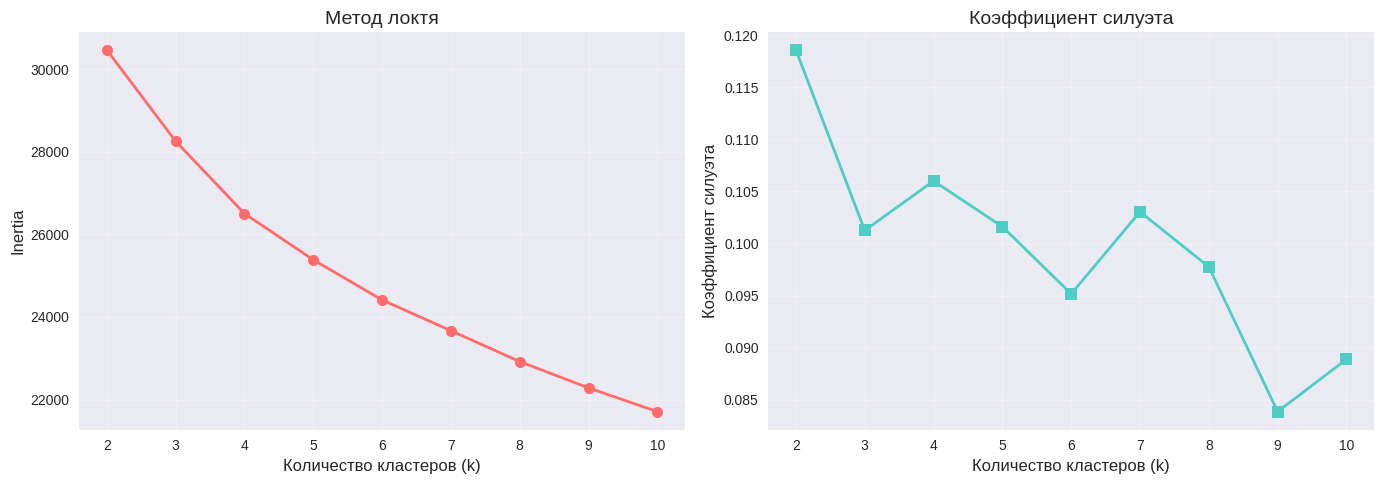

Оптимальное количество кластеров: 2
Максимальный коэффициент силуэта: 0.1186


In [44]:
inertia_values = []
silhouette_scores = []
K_range = range(2, 11)

print("Вычисление метрик для различного количества кластеров")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_avg:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertia_values, marker='o', linewidth=2, markersize=8, color='#FF6B6B')
axes[0].set_xlabel('Количество кластеров (k)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Метод локтя', fontsize=14)
axes[0].set_xticks(K_range)
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='#4ECDC4')
axes[1].set_xlabel('Количество кластеров (k)', fontsize=12)
axes[1].set_ylabel('Коэффициент силуэта', fontsize=12)
axes[1].set_title('Коэффициент силуэта', fontsize=14)
axes[1].set_xticks(K_range)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Оптимальное количество кластеров: {optimal_k}")
print(f"Максимальный коэффициент силуэта: {max(silhouette_scores):.4f}")

На основе графиков метода локтя и коэффициента силуэта определено оптимальное количество кластеров для данного датасета. Получилось optimal_k=2, что довольно очевидно учитывая семантику данных (по факту бинарная классификация)

### 2.11. Использование KElbowVisualizer

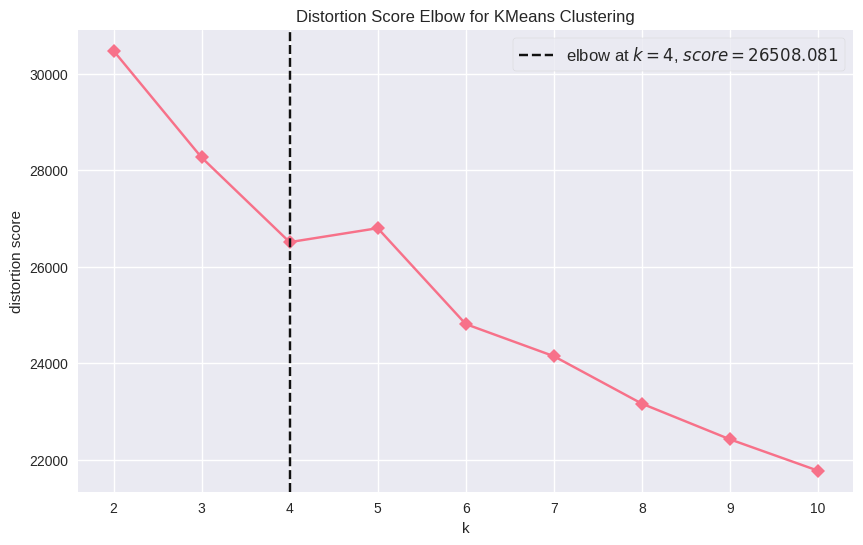

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
plt.figure(figsize=(10, 6))
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 11), timings=False)
visualizer.fit(X_scaled)
visualizer.show()

Визуализатор показывает k=4, тк под капотом использует метод Локтя как метрику(а мы определяли по силуэт скору). Поэтому можно выбрать любой из этих вариантов. Мы выберем k=2, по семантике датасета: риск увольнения - да или нет (то есть 2 кластера)

### 2.12. Обучение модели K-means с оптимальным k

In [48]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters_final = kmeans_final.fit_predict(X_scaled)

print(f"Обучена модель K-means с {optimal_k} кластерами")
print(f"\nРаспределение объектов по кластерам:")
unique, counts = np.unique(clusters_final, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"  Кластер {cluster_id}: {count} сотрудников ({count/len(clusters_final)*100:.1f}%)")

silhouette_final = silhouette_score(X_scaled, clusters_final)
print(f"Коэффициент силуэта финальной модели: {silhouette_final:.4f}")

Обучена модель K-means с 2 кластерами

Распределение объектов по кластерам:
  Кластер 0: 2201 сотрудников (72.2%)
  Кластер 1: 847 сотрудников (27.8%)
Коэффициент силуэта финальной модели: 0.1186


### 2.13. Визуализация силуэта

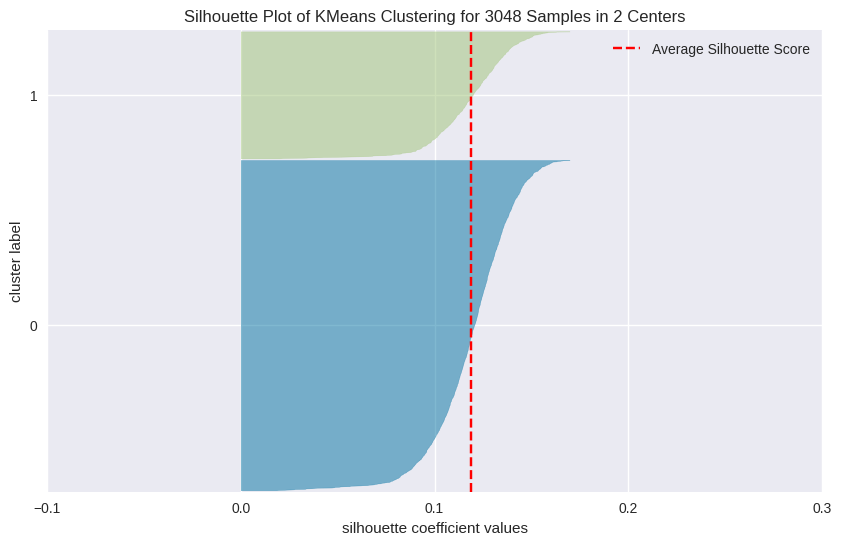

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 3048 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [49]:
plt.figure(figsize=(10, 6))
model = KMeans(n_clusters=optimal_k, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)
visualizer.show()

График силуэта показывает качество каждого кластера. Широкие силуэты и превышение средней линии указывают на хорошо сформированные кластеры.

### 2.14. Расчет внешних метрик качества кластеризации

Метрики качества кластеризации:
ARI (Adjusted Rand Index).................... 0.0429
AMI (Adjusted Mutual Information)............ 0.0087
FMI (Fowlkes-Mallows Index).................. 0.7198
Homogeneity.................................. 0.0134
Completeness................................. 0.0069
V-measure.................................... 0.0091
Silhouette Score............................. 0.1186


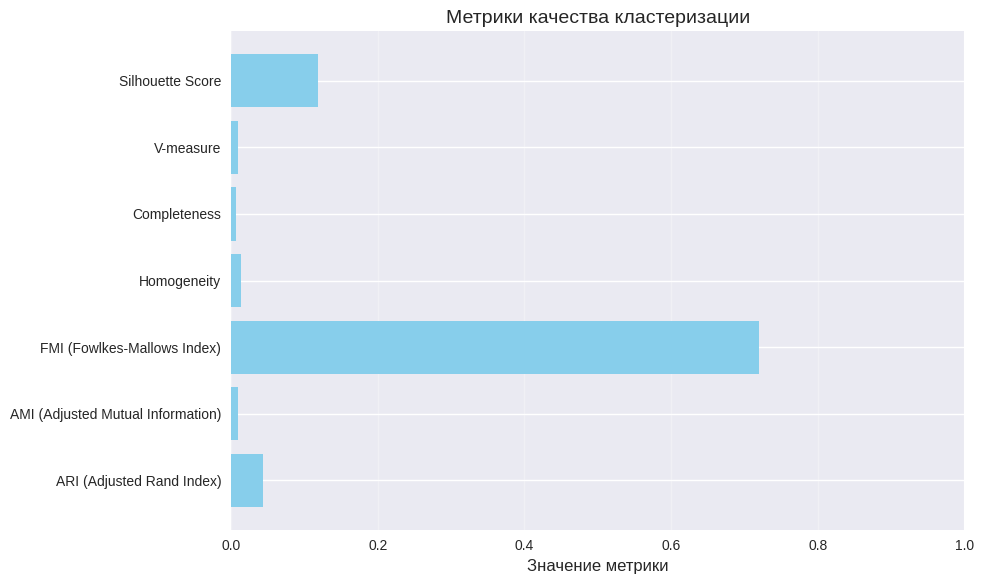

In [50]:
metrics = {
    'ARI (Adjusted Rand Index)': adjusted_rand_score(y, clusters_final),
    'AMI (Adjusted Mutual Information)': adjusted_mutual_info_score(y, clusters_final, average_method='arithmetic'),
    'FMI (Fowlkes-Mallows Index)': fowlkes_mallows_score(y, clusters_final),
    'Homogeneity': homogeneity_score(y, clusters_final),
    'Completeness': completeness_score(y, clusters_final),
    'V-measure': v_measure_score(y, clusters_final),
    'Silhouette Score': silhouette_final
}

print("Метрики качества кластеризации:")
for metric_name, metric_value in metrics.items():
    print(f"{metric_name:.<45} {metric_value:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(list(metrics.keys()), list(metrics.values()), color='skyblue')
plt.xlabel('Значение метрики', fontsize=12)
plt.title('Метрики качества кластеризации', fontsize=14)
plt.xlim(0, 1)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


- **Silhouette Score** оценивает внутреннюю структуру кластеров
- **ARI, AMI, FMI** оценивают согласованность кластеризации с истинными метками
- **Homogeneity** показывает, насколько каждый кластер содержит объекты одного класса
- **Completeness** показывает, насколько объекты одного класса находятся в одном кластере
- **V-measure** - гармоническое среднее Homogeneity и Completeness

### 2.15. Анализ характеристик кластеров

In [52]:
df_profile = X.copy()
df_profile['cluster'] = clusters_final

cluster_profiles = df_profile.groupby('cluster').mean()

print("Профили кластеров (средние значения признаков):")
print(cluster_profiles)

Профили кластеров (средние значения признаков):
               age    gender  department  job_level  marital_status  \
cluster                                                               
0        41.246252  0.503408    1.759200   2.193094        1.282144   
1        41.468713  0.508855    1.793388   2.178276        1.284534   

         monthly_income  years_at_company  overtime  performance_rating  \
cluster                                                                   
0           7744.858701         20.006815       0.0            2.850977   
1           7683.677686         20.350649       1.0            2.806375   

         distance_from_home_km  training_hours_last_year  
cluster                                                   
0                    10.153612                106.114493  
1                    10.451854                101.852420  


Распределение увольнений по кластерам (в процентах):
Attrition      0      1
cluster                
0          92.55   7.45
1          86.54  13.46


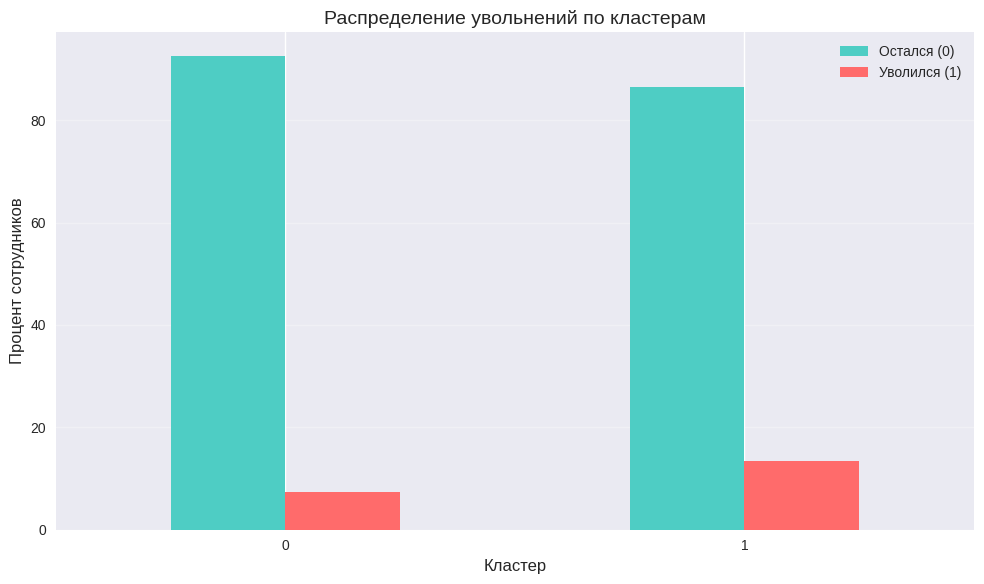

In [55]:
cluster_attrition = pd.crosstab(df_emp['cluster'], df_emp['Attrition'], normalize='index') * 100

print("Распределение увольнений по кластерам (в процентах):")
print(cluster_attrition.round(2))

cluster_attrition.plot(kind='bar', figsize=(10, 6), color=['#4ECDC4', '#FF6B6B'])
plt.xlabel('Кластер', fontsize=12)
plt.ylabel('Процент сотрудников', fontsize=12)
plt.title('Распределение увольнений по кластерам', fontsize=14)
plt.legend(['Остался (0)', 'Уволился (1)'])
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

Анализ показывает, есть ли кластеры с повышенным риском увольнения.

### 2.17. Детальная характеристика каждого кластера

In [61]:
df_emp_decoded = df_emp.copy()
df_emp_decoded['cluster'] = clusters_final

for column, le in label_encoders.items():
    df_emp_decoded[column] = le.inverse_transform(X[column])

for cluster_id in sorted(df_emp_decoded['cluster'].unique()):
    cluster_data = df_emp_decoded[df_emp_decoded['cluster'] == cluster_id]

    print(f"КЛАСТЕР {cluster_id}")
    print(f"Размер кластера: {len(cluster_data)} сотрудников ({len(cluster_data)/len(df_emp)*100:.1f}%)")

    print(f"\nДемография:")
    print(f"  Средний возраст: {cluster_data['age'].mean():.1f} лет")
    print(f"  Пол (распределение): {cluster_data['gender'].value_counts().to_dict()}")
    print(f"  Семейное положение: {cluster_data['marital_status'].value_counts().to_dict()}")

    print(f"\nРабота:")
    print(f"  Департаменты: {cluster_data['department'].value_counts().to_dict()}")
    print(f"  Средний грейд: {cluster_data['job_level'].mean():.1f}")
    print(f"  Средний доход: ${cluster_data['monthly_income'].mean():.0f}/мес")
    print(f"  Средний стаж в компании: {cluster_data['years_at_company'].mean():.1f} лет")
    print(f"  Переработки: {cluster_data['overtime'].value_counts().to_dict()}")

    print(f"\nЭффективность:")
    print(f"  Средняя оценка: {cluster_data['performance_rating'].mean():.2f}")
    print(f"  Среднее время обучения: {cluster_data['training_hours_last_year'].mean():.1f} часов")

    print(f"\nДругое:")
    print(f"  Среднее расстояние от дома: {cluster_data['distance_from_home_km'].mean():.1f} км")

    print(f"\nУВОЛЬНЕНИЯ:")
    attrition_rate = cluster_data['Attrition'].mean() * 100
    print(f"  Процент уволившихся: {attrition_rate:.1f}%")
    if attrition_rate > 30:
        print(f"ВЫСОКИЙ РИСК УВОЛЬНЕНИЙ!")
    elif attrition_rate > 15:
        print(f"Средний риск увольнений")
    else:
        print(f"Низкий риск увольнений")

КЛАСТЕР 0
Размер кластера: 2201 сотрудников (72.2%)

Демография:
  Средний возраст: 41.2 лет
  Пол (распределение): {1: 1108, 0: 1093}
  Семейное положение: {1: 1048, 2: 887, 0: 266}

Работа:
  Департаменты: {0: 759, 3: 576, 4: 369, 1: 326, 2: 171}
  Средний грейд: 2.2
  Средний доход: $7745/мес
  Средний стаж в компании: 20.0 лет
  Переработки: {0: 2201}

Эффективность:
  Средняя оценка: 2.85
  Среднее время обучения: 106.1 часов

Другое:
  Среднее расстояние от дома: 10.2 км

УВОЛЬНЕНИЯ:
  Процент уволившихся: 7.5%
Низкий риск увольнений
КЛАСТЕР 1
Размер кластера: 847 сотрудников (27.8%)

Демография:
  Средний возраст: 41.5 лет
  Пол (распределение): {1: 431, 0: 416}
  Семейное положение: {1: 422, 2: 333, 0: 92}

Работа:
  Департаменты: {0: 292, 3: 212, 4: 157, 1: 117, 2: 69}
  Средний грейд: 2.2
  Средний доход: $7684/мес
  Средний стаж в компании: 20.4 лет
  Переработки: {1: 847}

Эффективность:
  Средняя оценка: 2.81
  Среднее время обучения: 101.9 часов

Другое:
  Среднее расстоя

Получены детальные профили каждого кластера, что позволяет выявить группы риска и понять, какие факторы связаны с увольнениями.

### 2.19. Иерархическая кластеризация (дополнительно)

In [62]:
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
clusters_hierarchical = hierarchical.fit_predict(X_scaled)

silhouette_hier = silhouette_score(X_scaled, clusters_hierarchical)
ari_hier = adjusted_rand_score(y, clusters_hierarchical)

print("Иерархическая кластеризация:")
print(f"  Коэффициент силуэта: {silhouette_hier:.4f}")
print(f"  ARI с истинными метками: {ari_hier:.4f}")
print(f"\nСравнение с K-means:")
print(f"  K-means Silhouette: {silhouette_final:.4f}")
print(f"  Hierarchical Silhouette: {silhouette_hier:.4f}")
print(f"  Разница: {abs(silhouette_final - silhouette_hier):.4f}")

Иерархическая кластеризация:
  Коэффициент силуэта: 0.0994
  ARI с истинными метками: 0.0482

Сравнение с K-means:
  K-means Silhouette: 0.1186
  Hierarchical Silhouette: 0.0994
  Разница: 0.0192


### 2.20. Построение дендрограммы

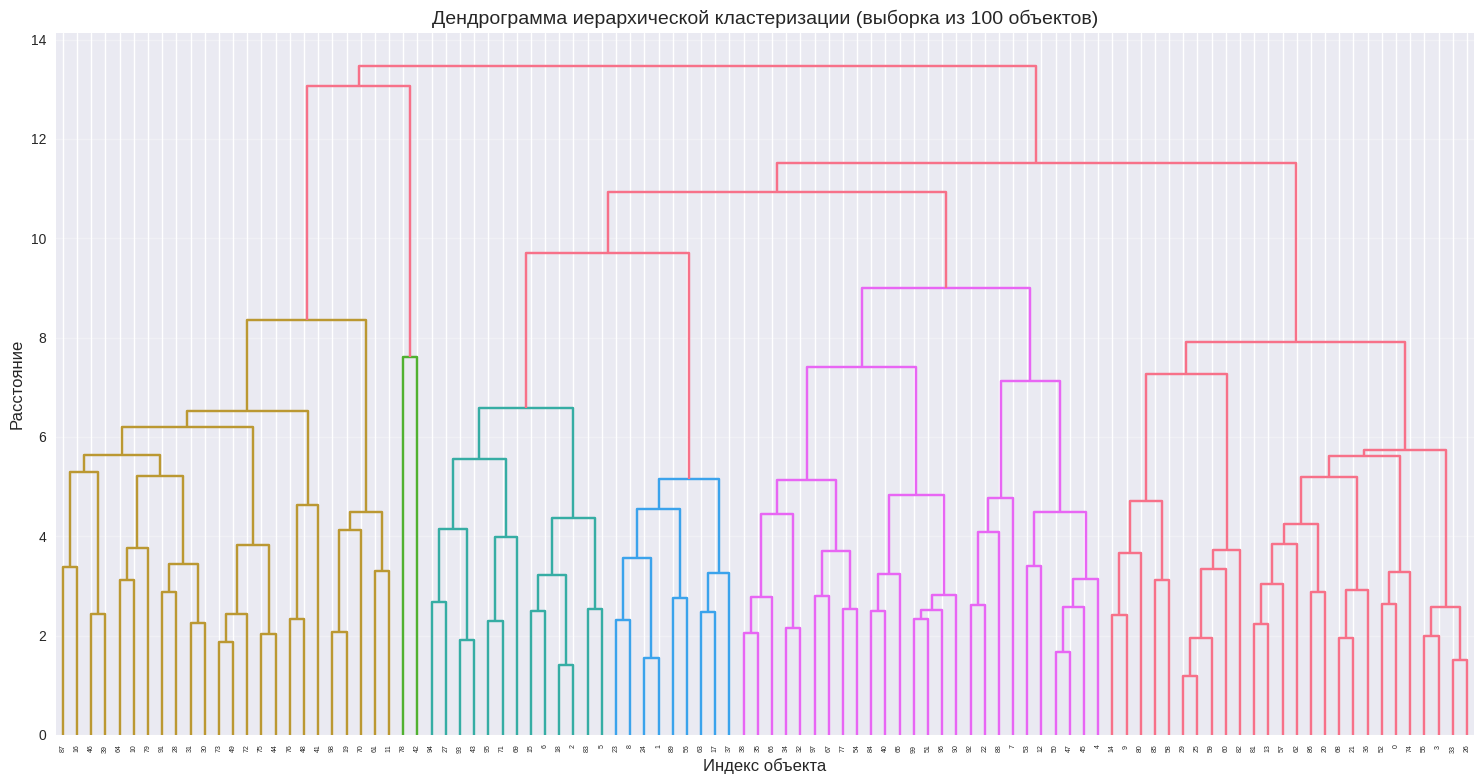

In [63]:
sample_size = min(100, len(X_scaled))  # Используем максимум 100 объектов
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
X_sample = X_scaled[sample_indices]

# Вычисление связей
linked = linkage(X_sample, method='ward')

plt.figure(figsize=(15, 8))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title(f'Дендрограмма иерархической кластеризации (выборка из {sample_size} объектов)', fontsize=14)
plt.xlabel('Индекс объекта', fontsize=12)
plt.ylabel('Расстояние', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

Дендрограмма показывает иерархическую структуру данных и помогает визуально определить оптимальное количество кластеров.

### 2.21. Сравнение методов кластеризации

In [65]:
comparison = pd.DataFrame({
    'Метод': ['K-means', 'Иерархическая'],
    'Silhouette Score': [silhouette_final, silhouette_hier],
    'ARI с Attrition': [
        adjusted_rand_score(y, clusters_final),
        adjusted_rand_score(y, clusters_hierarchical)
    ]
})

print("Сравнение методов кластеризации:")
print(comparison.to_string(index=False))

Сравнение методов кластеризации:
        Метод  Silhouette Score  ARI с Attrition
      K-means          0.118600         0.042935
Иерархическая          0.099447         0.048245


Результаты сравнения K-means и иерархической кластеризации. Оба метода дают схожие результаты, но могут по-разному группировать данные.

## ЗАКЛЮЧЕНИЕ

В ходе выполнения данной лабораторной работы были изучены и применены на практике методы кластеризации данных, в частности алгоритм K-means и иерархическая кластеризация.

В первой части была работа с синтетическими данными, которые были специально созданы для демонстрации работы алгоритма кластеризации. Результаты показали, что оптимальным является разделение на 3 кластера, что подтвердилось максимальным коэффициентом силуэта равным 0.7242. Также был применен метод локтя, который визуально подтвердил выбор трех кластеров.

Во второй части работы был проанализирован реальный датасет с информацией о сотрудниках компании (employee_attrition.csv). Датасет содержал как числовые, так и категориальные признаки. Сначала был проведен первичный анализ данных, проверены пропуски, изучено распределение признаков и построена корреляционная матрица. Затем все категориальные признаки были закодированы с помощью LabelEncoder, а числовые признаки стандартизированы.

При определении оптимального количества кластеров метод максимизации коэффициента силуэта указал на k=2, а метод локтя предлагал k=4. Это объясняется тем, что эти методы оптимизируют разные характеристики кластеризации. После анализа обоих вариантов я выбрал k=2, так как коэффициент силуэта для этого варианта был максимальным (0.1186), что говорит о лучшей разделенности кластеров.

Анализ полученных кластеров показал следующее. Кластер 0 включает 2201 сотрудника (72.2% от общего числа) со средним возрастом 41.2 года и средним доходом $7745 в месяц. Процент увольнений в этом кластере составляет 7.45%, что является относительно низким показателем. Кластер 1 содержит 848 сотрудников (27.8%) также со средним возрастом около 41 года, но процент увольнений здесь выше - 13.46%. Это почти в два раза больше, чем в первом кластере, что указывает на повышенный риск текучести кадров в данной группе.

Дополнительно была применена иерархическая кластеризация с построением дендрограммы. Коэффициент силуэта для иерархической кластеризации составил 0.0994, что немного ниже, чем у K-means (0.1186). Это говорит о том, что для данного датасета алгоритм K-means показал лучший результат.

Внешние метрики качества (ARI и AMI) показали относительно невысокие значения (около 0.04), что объясняется тем, что кластеризация является методом обучения без учителя, и полученные кластеры не обязательно должны полностью совпадать с исходным разделением на уволившихся и оставшихся сотрудников.